In [ ]:
import pandas as pd
from prettytable import PrettyTable
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import zipfile

In [ ]:
!wget https://github.com/sidooms/MovieTweetings/archive/refs/heads/master.zip

--2024-01-23 17:26:04--  https://github.com/sidooms/MovieTweetings/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/sidooms/MovieTweetings/zip/refs/heads/master [following]
--2024-01-23 17:26:04--  https://codeload.github.com/sidooms/MovieTweetings/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.4’

master.zip.4            [             <=>    ]  85.84M  11.5MB/s    in 7.4s    

2024-01-23 17:26:12 (11.5 MB/s) - ‘master.zip.4’ saved [90007358]



In [ ]:
!unzip master.zip

Archive:  master.zip
44c525d0c766944910686c60697203cda39305d6
replace MovieTweetings-master/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/latest/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/latest/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/latest/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/recsyschallenge2014/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/recsyschallenge2014/dataset_split.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/recsyschallenge2014/recsys_challenge_2014_dataset.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/snapshots/100K/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MovieTweetings-master/snapshots/100K/ratings.dat? [y]es, [n]o, [A]ll, [

In [ ]:
# You can change this section
# select subset of users
subset = 200



In [ ]:
df = pd.read_csv('MovieTweetings-master/latest/ratings.dat', names=['rate'])

In [ ]:
movies_cols=['movie_id', 'movie_title(movie_year)','genres']

with zipfile.ZipFile('master.zip', 'r') as zip_ref:
    zip_ref.extractall()

movies_df = pd.read_csv('MovieTweetings-master/latest/movies.dat', sep='::',
                        engine='python', names=movies_cols)


# split pipe-separated genres into separate rows
movies_df = movies_df.assign(genres=movies_df['genres'].str.split('|')).explode('genres')

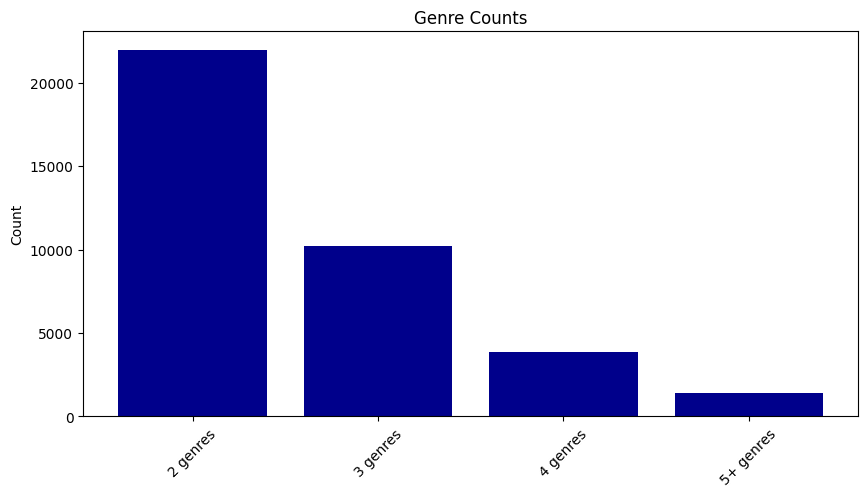

In [ ]:
# Get genre counts categories
genre_counts_cat = movies_df.groupby('movie_id')['genres'].count()
genre_counts_cat = pd.cut(genre_counts_cat, bins=[0,2,3,4,5],
                          labels=['2 genres','3 genres','4 genres','5+ genres'])

def _plot_series(series, series_name):
  counted = (series
             .value_counts()
             .reset_index(name='counts'))

  xs = counted['index']
  ys = counted['counts']

  plt.bar(xs, ys, color='darkblue')
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.title(series_name)

fig, ax = plt.subplots(figsize=(10,5))

_plot_series(genre_counts_cat, 'Genre Counts')

plt.show()

In [ ]:
#Split the 'data' column into separate columns
df[['user_id', 'movie_id', 'rating', 'rating_timestamp']] = df['rate'].str.split('::', expand=True)

#Convert columns to appropriate data types
df['user_id'] = df['user_id'].astype(int)
df['movie_id'] = df['movie_id'].astype(str)
df['rating'] = df['rating'].astype(int)

#Get a random subset of users
random_users = random.sample(list(df['user_id'].unique()), subset)

#Filter the dataframe to include only the random users
df_subset = df[df['user_id'].isin(random_users)]

df = df.drop(columns=['rate'])

In [ ]:
df = df.where(df['user_id'] <= subset).dropna()

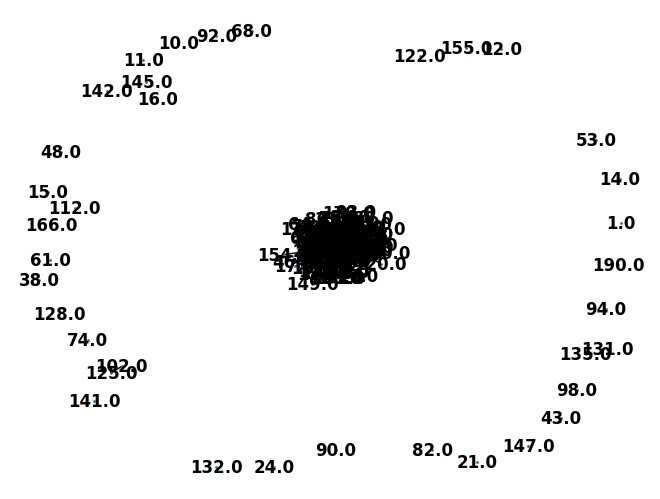

In [ ]:
# Create a graph
graph = nx.Graph()

# Create nodes for each user
graph.add_nodes_from(df['user_id'].unique())

# Create edges between users who have at least one movie in common
for movie_id, users in df.groupby('movie_id')['user_id']:
    user_pairs = list(itertools.combinations(users, 2))
    graph.add_edges_from(user_pairs)
# # Plot the graph with interactive notebook mode

# pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, font_weight='bold', node_size=1)

plt.show()

In [ ]:
dataset = []
for movie_id, users in df.groupby('movie_id')['user_id']:
    dataset.append([user for user in users])

In [ ]:
def generate_candidates(prev_candidates, k):
    candidates = set()
    for i in range(len(prev_candidates)):
        for j in range(i + 1, len(prev_candidates)):
            union_set = prev_candidates[i].union(prev_candidates[j])
            if len(union_set) == k:
                candidates.add(frozenset(union_set))
    return list(candidates)

def apriori(dataset, min_support):
    transactions = [set(transaction) for transaction in dataset]
    candidates = [frozenset([item]) for item in set.union(*transactions)]
    frequent_items = []
    k = 2

    while candidates:
        # Count candidate itemsets in transactions
        candidate_counts = {candidate: 0 for candidate in candidates}
        for transaction in transactions:
            for candidate in candidates:
                if candidate.issubset(transaction):
                    candidate_counts[candidate] += 1

        # Prune candidates based on minimum support
        frequent_items = []
        candidates = [candidate for candidate, count in candidate_counts.items() if count >= min_support]
        for candidate, count in candidate_counts.items():
            if count >= min_support:
                frequent_items.append(1)
            else:
                frequent_items.append(0)

        # Output frequent itemsets with support count
        if len(candidates)>0:
            Final_candidates = candidates
        print(f"Level {k - 1}:")
        columns = ["ItemSet", "sup_count", "frequent_items"]
        myTable = PrettyTable()
        myTable.add_column(columns[0],list(candidate_counts.keys()))
        myTable.add_column(columns[1],list(candidate_counts.values()))
        myTable.add_column(columns[2],frequent_items)
        print(myTable, '\n')

        # Generate new candidates
        candidates = generate_candidates(candidates, k)
        k += 1
    return Final_candidates



In [ ]:
def add_nodes(nodes_for_process, Final_nodes):
    new_nodes = [set() for i in range(len(Final_nodes))]
    sum_val = 0
    for idx, cluster in enumerate(nodes_for_process):
        for node in cluster:
            node_edges = list(graph.edges(node))
            edge_number = len(node_edges)
            if edge_number > th1:
                new = set([i[1] for i in node_edges])
                new_nodes[idx] = new_nodes[idx].union(new)
                sum_val += len(new)
                Final_nodes[idx] = Final_nodes[idx].union(new)
    return Final_nodes, new_nodes, sum_val



In [ ]:
# Initialize lists to store results for plotting
num_clusters_list = []
num_nodes_list = []
num_accepted_frozensets_list = []
# Loop for different min_support values
min_support_values = range(2,200)

for min_support in min_support_values:
    # Step 2 (Apriori algorithm)
    Final_candidates = apriori(dataset, min_support)

    # Step 3
    beta = 0
    step3_nodes = set()
    for i in Final_candidates:
        item = list(i)
        for m in range(len(item)):
            for n in range(m + 1, len(item)):
                if m != n:
                    try:
                        shortest_path = nx.shortest_path(graph, source=item[m], target=item[n])
                        if len(shortest_path) - 2 <= beta:
                            for j in shortest_path:
                                step3_nodes.add(j)
                    except:
                        shortest_path = None
    step3_nodes = [set([i]) for i in step3_nodes]

    # Step 4
    th1 = 3
    th2 = 0.30
    new_nodes = step3_nodes
    Final_nodes = new_nodes
    generated_final_nodes = Final_nodes
    sum_val = len(new_nodes)
    while sum_val > th2 * (len(new_nodes)):
        Final_nodes = generated_final_nodes
        generated_final_nodes, new_nodes, sum_val = add_nodes(new_nodes, Final_nodes)
        th2 *= 2  # optional


    num_accepted_frozensets = len(Final_candidates)
    num_accepted_frozensets_list.append(num_accepted_frozensets)

    # Calculate number of nodes in each cluster
    nodes_in_clusters = [len(cluster) for cluster in Final_nodes]
    num_nodes_list.append(nodes_in_clusters)

    num_clusters = len(Final_nodes)
    num_clusters_list.append(num_clusters)
    # Placeholder: Add your code for further analysis or visualization based on Final_nodes and generated_final_nodes
    print(f"Results for min_support = {min_support}")
    print("Final_nodes:", Final_nodes)
    print("Generated final nodes:", generated_final_nodes)
    print("\n")


Streaming output truncated to the last 5000 lines.
| frozenset({57.0})  |     3     |       0        |
| frozenset({58.0})  |     14    |       0        |
| frozenset({59.0})  |     3     |       0        |
| frozenset({60.0})  |     14    |       0        |
| frozenset({61.0})  |     1     |       0        |
| frozenset({62.0})  |     1     |       0        |
| frozenset({63.0})  |     16    |       0        |
| frozenset({64.0})  |     1     |       0        |
| frozenset({65.0})  |     1     |       0        |
| frozenset({66.0})  |    315    |       1        |
| frozenset({67.0})  |     1     |       0        |
| frozenset({68.0})  |     1     |       0        |
| frozenset({69.0})  |    121    |       0        |
| frozenset({70.0})  |     1     |       0        |
| frozenset({71.0})  |     4     |       0        |
| frozenset({72.0})  |     2     |       0        |
| frozenset({73.0})  |     6     |       0        |
| frozenset({74.0})  |     1     |       0        |
| frozenset({

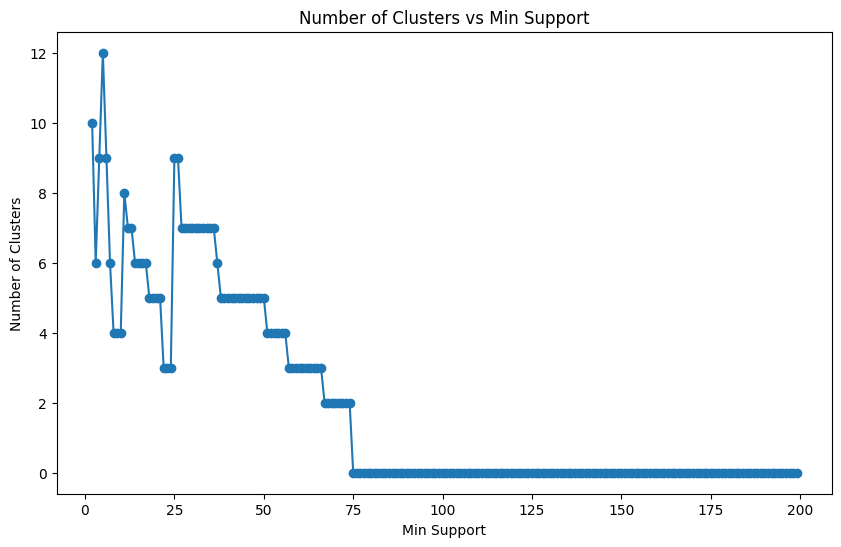

In [ ]:
# Check the length of the arrays
if len(min_support_values) != len(num_clusters_list):
    raise ValueError("The dimensions of min_support_values and num_clusters_list do not match.")


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(min_support_values, num_clusters_list, marker='o')
plt.title('Number of Clusters vs Min Support')
plt.xlabel('Min Support')
plt.ylabel('Number of Clusters')

plt.show()

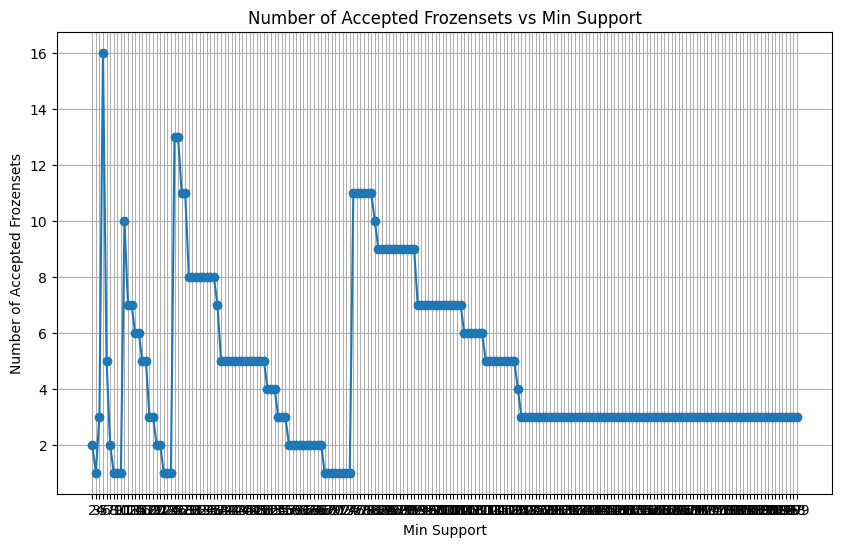

In [ ]:

# Plotting number of accepted frozensets
plt.figure(figsize=(10, 6))
plt.plot(min_support_values, num_accepted_frozensets_list, marker='o')
plt.title('Number of Accepted Frozensets vs Min Support')
plt.xlabel('Min Support')
plt.ylabel('Number of Accepted Frozensets')
plt.xticks(min_support_values)
plt.grid(True)
plt.show()

